# Face Detection and Clustering using Deepface

1. The objective of this notebook is to detect faces in images and cluster them based on the detected faces.
2. The faces will be extracted and put into a separate folder.

In [1]:
import os
import random
from tqdm import tqdm
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepface import DeepFace

## Dataset

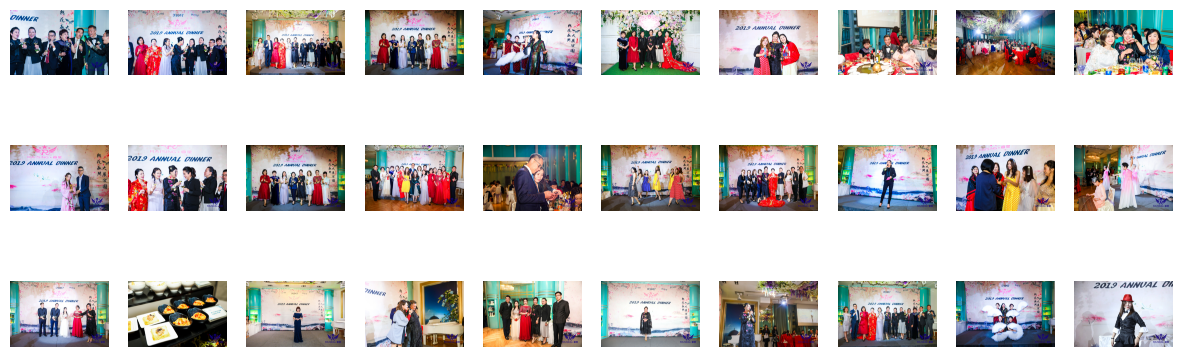

In [5]:
dataset_path = "dataset"

image_files = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path) if file.endswith(".jpg")]

random_images = random.sample(image_files, 30)
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    image = Image.open(random_images[i])
    ax.imshow(image)
    ax.axis("off")
    
plt.show()

## Face Detection and Encoding

1. The goal of this section is to extract the faces in the images and encode them.
2. The face encoding will be used to cluster the faces.

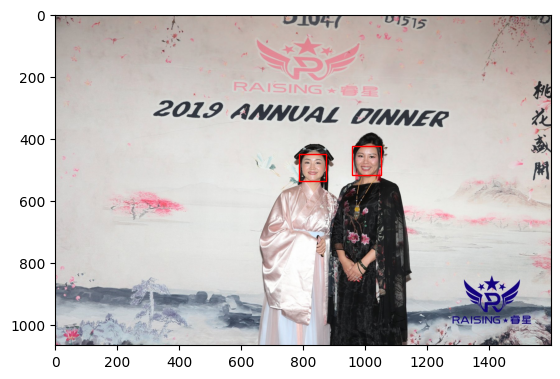

In [6]:
# Test for 1 image

img_path = dataset_path + "/0.jpg"
res = DeepFace.represent(img_path = img_path, model_name="GhostFaceNet")

# Plot the image and the rectangle of the face
fig, ax = plt.subplots()

image = Image.open(img_path)
ax.imshow(image)

for face in res:
    x, y, w, h, _, _ = face['facial_area'].values()
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
    ax.add_patch(rect)
    
plt.show()

### Extracting Faces from all image in dataset

The faces will be extracted from each image in the dataset and will be stored in a dataframe with below schema

| id | image_path | bounding_box | encoding |

In [9]:
def extract_faces(img_path: str, model_name: str = "GhostFaceNet") -> list:
    """
    Extracts faces from an image using a specified model.

    Args:
        img_path (str): The path to the image file.
        model_name (str): The name of the model to use for face extraction.

    Returns:
        list: A list of dictionaries containing the bounding box and embedding for each extracted face.
            - bounding_box (list): A list containing the bounding box coordinates of the face (x, y, w, h)
            - embedding (list): A list containing the embedding of the face. (size varies depending on the model)
    """
    
    try:
        res = DeepFace.represent(img_path = img_path, model_name=model_name, detector_backend='retinaface')
    except:
        return []

    faces = []
    
    for face in res:
        x, y, w, h, _, _ = face['facial_area'].values()
        embedding = face['embedding']
        
        faces.append({
            'bounding_box': [x, y, w, h],
            'embedding': embedding
        })
        
    return faces

### VGG-Face

In [10]:
# Extract faces from the dataset

extracted_faces = {
    'img_path': [],
    'bounding_box': [],
    'embedding': []
}

uncessful_images = []

for filename in tqdm(os.listdir(dataset_path)):
    
    if filename.endswith(".jpg"):
        
        img_path = os.path.join(dataset_path, filename)
        faces = extract_faces(img_path, 'VGG-Face')
        
        if faces == []:
            uncessful_images.append(filename)
            continue
        
        for face in faces:
            extracted_faces['img_path'].append(img_path)
            extracted_faces['bounding_box'].append(face['bounding_box'])
            extracted_faces['embedding'].append(face['embedding'])

100%|██████████| 672/672 [05:12<00:00,  2.15it/s]


In [12]:
print("uncessful_images:", len(uncessful_images))

uncessful_images: 10


In [16]:
df = pd.DataFrame(extracted_faces)
df

,img_path,bounding_box,embedding
0,dataset/63.jpg,"[831, 420, 48, 61]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,dataset/63.jpg,"[1239, 418, 45, 55]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,dataset/63.jpg,"[1155, 439, 46, 56]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,dataset/63.jpg,"[940, 422, 45, 56]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,dataset/63.jpg,"[610, 451, 43, 55]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
5543,dataset/184.jpg,"[995, 303, 116, 123]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5544,dataset/184.jpg,"[751, 351, 106, 135]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5545,dataset/184.jpg,"[1427, 301, 90, 142]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5546,dataset/184.jpg,"[29, 346, 100, 135]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
df.to_pickle("result/extract/extracted_faces_vggface.pkl")

In [2]:
df = pd.read_pickle("result/extract/extracted_faces_vggface.pkl")

In [5]:
len(df['embedding'].iloc[0])

4096

#### Clustering Faces

1. The goal of this section is to cluster the faces based on its embeddings.
2. The result of the clustering will be stored in a seperate folder for each cluster

In [138]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [139]:
embeddings = np.array(df['embedding'].tolist())

In [20]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

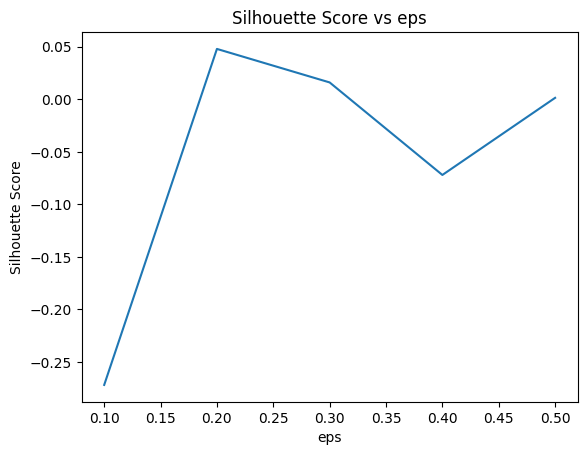

In [144]:
# Get the best eps value

eps_values = np.arange(0.1, 0.6, 0.1)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, metric="cosine")
    clusters = dbscan.fit_predict(embeddings_scaled)
    
    silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
    silhouette_scores.append(silhouette_avg)
    
plt.plot(eps_values, silhouette_scores)
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs eps")
plt.show()

In [152]:
dbscan = DBSCAN(eps=0.2, metric="cosine")
clusters = dbscan.fit_predict(embeddings_scaled)

In [153]:
# Check the number of clusters and noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 91
Estimated number of noise points: 2533


In [154]:
silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.048


In [155]:
df['cluster'] = clusters

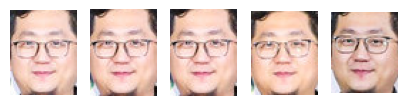

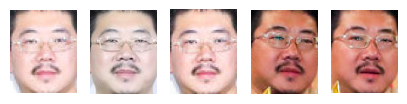

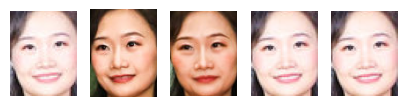

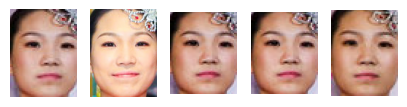

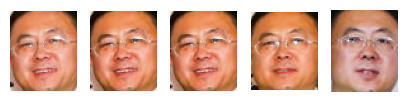

In [156]:
for x in range(5):
    cluster_0 = df[df['cluster'] == x]
    cluster_0 = cluster_0.reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        image = Image.open(cluster_0['img_path'][i])
        x, y, w, h = cluster_0['bounding_box'][i]
        face = image.crop((x, y, x+w, y+h))
        ax.imshow(face)
        ax.axis("off")

In [28]:
# For each cluster create a folder and save all the images in that cluster

for cluster in set(clusters):
    cluster_path = f"result/cluster/clusters_vggface/cluster_{cluster}"
    os.makedirs(cluster_path, exist_ok=True)
    
    cluster_df = df[df['cluster'] == cluster]
    
    for i, row in cluster_df.iterrows():
        img_path = row['img_path']
        image = Image.open(img_path)
        x, y, w, h = row['bounding_box']
        face = image.crop((x, y, x+w, y+h))
        
        face.save(f"{cluster_path}/{i}.jpg")

### Facenet 512

In [29]:
# Extract faces from the dataset

extracted_faces = {
    'img_path': [],
    'bounding_box': [],
    'embedding': []
}

uncessful_images = []

for filename in tqdm(os.listdir(dataset_path)):
    
    if filename.endswith(".jpg"):
        
        img_path = os.path.join(dataset_path, filename)
        faces = extract_faces(img_path, 'Facenet512')
        
        if faces == []:
            uncessful_images.append(filename)
            continue
        
        for face in faces:
            extracted_faces['img_path'].append(img_path)
            extracted_faces['bounding_box'].append(face['bounding_box'])
            extracted_faces['embedding'].append(face['embedding'])

  0%|          | 0/672 [00:00<?, ?it/s]

100%|██████████| 672/672 [29:25<00:00,  2.63s/it]  


In [30]:
print("uncessful_images:", len(uncessful_images))

uncessful_images: 10


In [31]:
df = pd.DataFrame(extracted_faces)
df

,img_path,bounding_box,embedding
0,dataset/63.jpg,"[831, 420, 48, 61]","[1.5592315196990967, 0.09766927361488342, -0.7..."
1,dataset/63.jpg,"[1239, 418, 45, 55]","[-0.3188968896865845, -0.20925045013427734, -0..."
2,dataset/63.jpg,"[1155, 439, 46, 56]","[0.08671119064092636, 0.5888829827308655, -0.8..."
3,dataset/63.jpg,"[940, 422, 45, 56]","[1.635267734527588, -0.26187068223953247, 0.23..."
4,dataset/63.jpg,"[610, 451, 43, 55]","[0.9314680099487305, 1.0797431468963623, -0.65..."
...,...,...,...
5543,dataset/184.jpg,"[995, 303, 116, 123]","[0.9314330816268921, 1.5968962907791138, -1.31..."
5544,dataset/184.jpg,"[751, 351, 106, 135]","[0.9366321563720703, -0.33862560987472534, -0...."
5545,dataset/184.jpg,"[1427, 301, 90, 142]","[0.2458135038614273, 0.9399695992469788, -1.36..."
5546,dataset/184.jpg,"[29, 346, 100, 135]","[1.5178472995758057, 0.16571147739887238, 1.01..."


In [32]:
df.to_pickle("result/extract/extracted_faces_facenet512.pkl")

In [6]:
df = pd.read_pickle("result/extract/extracted_faces_facenet512.pkl")

In [7]:
len(df['embedding'].iloc[0])

512

#### Clustering Faces

1. The goal of this section is to cluster the faces based on its embeddings.
2. The result of the clustering will be stored in a seperate folder for each cluster

In [185]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [186]:
embeddings = np.array(df['embedding'].tolist())

In [187]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

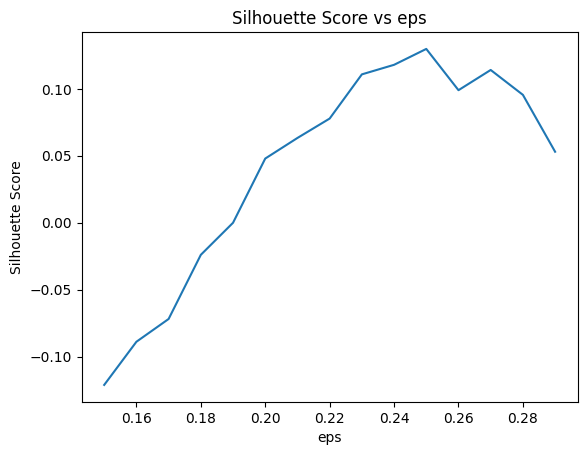

In [188]:
# Get the best eps value

eps_values = np.arange(0.15, 0.3, 0.01)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, metric="cosine")
    clusters = dbscan.fit_predict(embeddings_scaled)
    
    silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
    silhouette_scores.append(silhouette_avg)
    
plt.plot(eps_values, silhouette_scores)
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs eps")
plt.show()

In [189]:
dbscan = DBSCAN(eps=0.25, metric="cosine")
clusters = dbscan.fit_predict(embeddings_scaled)

In [190]:
# Check the number of clusters and noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 95
Estimated number of noise points: 1862


In [191]:
silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.130


In [192]:
df['cluster'] = clusters

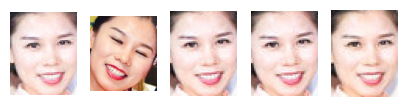

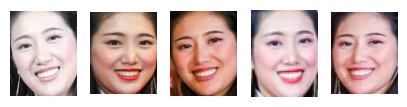

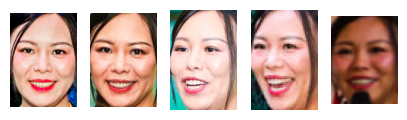

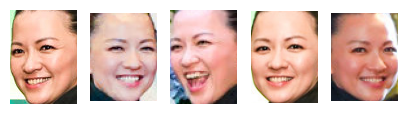

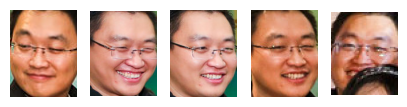

In [193]:
for x in range(10, 15):
    cluster_0 = df[df['cluster'] == x]
    cluster_0 = cluster_0.reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        image = Image.open(cluster_0['img_path'][i])
        x, y, w, h = cluster_0['bounding_box'][i]
        face = image.crop((x, y, x+w, y+h))
        ax.imshow(face)
        ax.axis("off")

In [194]:
# For each cluster create a folder and save all the images in that cluster

for cluster in set(clusters):
    cluster_path = f"result/cluster/clusters_facenet512/cluster_{cluster}"
    os.makedirs(cluster_path, exist_ok=True)
    
    cluster_df = df[df['cluster'] == cluster]
    
    for i, row in cluster_df.iterrows():
        img_path = row['img_path']
        image = Image.open(img_path)
        x, y, w, h = row['bounding_box']
        face = image.crop((x, y, x+w, y+h))
        
        face.save(f"{cluster_path}/{i}.jpg")

### CLIP

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('clip-ViT-L-14')

In [ ]:
def extract_faces(img_path: str, model_name: str = "CLIP") -> list:
    """
    Extracts faces from an image using a specified model.

    Args:
        img_path (str): The path to the image file.
        model_name (str): The name of the model to use for face extraction.

    Returns:
        list: A list of dictionaries containing the bounding box and embedding for each extracted face.
            - bounding_box (list): A list containing the bounding box coordinates of the face (x, y, w, h)
            - embedding (list): A list containing the embedding of the face. (size varies depending on the model)
    """
    
    if model_name == 'CLIP':
        
        res = []
        
        # Detect the face first
        try:
            face_objs = DeepFace.extract_faces(img_path = img_path, detector_backend = 'retinaface')
        except:
            face_objs = []
        

        # For each face detected, extract the embedding
        for face_obj in face_objs:
            x, y, w, h, _, _ = face_objs[0]['facial_area'].values()
            img = Image.open(img_path).crop((x, y, x+w, y+h))
            image_features = model.encode(img)
                    
            res.append( {
                    'facial_area' : face_obj['facial_area'],
                    'embedding': image_features
            })
    
    else:
        try:
            res = DeepFace.represent(img_path = img_path, model_name=model_name)
        except:
            return []

    faces = []
    
    for face in res:
        x, y, w, h, _, _ = face['facial_area'].values()
        embedding = face['embedding']
        
        faces.append({
            'bounding_box': [x, y, w, h],
            'embedding': embedding
        })
        
    return faces

In [ ]:
# Extract faces from the dataset

extracted_faces = {
    'img_path': [],
    'bounding_box': [],
    'embedding': []
}

uncessful_images = []

for filename in tqdm(os.listdir(dataset_path)):
    
    if filename.endswith(".jpg"):
        
        img_path = os.path.join(dataset_path, filename)
        faces = extract_faces(img_path, model_name = "CLIP")
        
        if faces == []:
            uncessful_images.append(filename)
            continue
        
        for face in faces:
            extracted_faces['img_path'].append(img_path)
            extracted_faces['bounding_box'].append(face['bounding_box'])
            extracted_faces['embedding'].append(face['embedding'])

In [ ]:
df = pd.DataFrame(extracted_faces)
df

,img_path,bounding_box,embedding
0,dataset/63.jpg,"[831, 420, 48, 61]","[0.0065617897, 0.6275274, 0.48500958, 0.022933..."
1,dataset/63.jpg,"[1239, 418, 45, 55]","[0.0065617897, 0.6275274, 0.48500958, 0.022933..."
2,dataset/63.jpg,"[1155, 439, 46, 56]","[0.0065617897, 0.6275274, 0.48500958, 0.022933..."
3,dataset/63.jpg,"[940, 422, 45, 56]","[0.0065617897, 0.6275274, 0.48500958, 0.022933..."
4,dataset/63.jpg,"[610, 451, 43, 55]","[0.0065617897, 0.6275274, 0.48500958, 0.022933..."
...,...,...,...
5543,dataset/184.jpg,"[995, 303, 116, 123]","[0.5036328, 0.20555115, 0.46419653, 0.83934456..."
5544,dataset/184.jpg,"[751, 351, 106, 135]","[0.5036328, 0.20555115, 0.46419653, 0.83934456..."
5545,dataset/184.jpg,"[1427, 301, 90, 142]","[0.5036328, 0.20555115, 0.46419653, 0.83934456..."
5546,dataset/184.jpg,"[29, 346, 100, 135]","[0.5036328, 0.20555115, 0.46419653, 0.83934456..."


In [ ]:
df.to_pickle("result/extract/extracted_faces_clip.pkl")

In [8]:
df = pd.read_pickle("result/extract/extracted_faces_clip.pkl")

In [9]:
len(df['embedding'].iloc[0])

768

#### Clustering Faces

1. The goal of this section is to cluster the faces based on its embeddings.
2. The result of the clustering will be stored in a seperate folder for each cluster

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
embeddings = np.array(df['embedding'].tolist())

In [ ]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

In [ ]:
dbscan = DBSCAN(eps=0.5, metric="cosine")
clusters = dbscan.fit_predict(embeddings_scaled)

In [ ]:
# Check the number of clusters and noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 70
Estimated number of noise points: 67


In [ ]:
silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: -0.008


In [ ]:
df['cluster'] = clusters

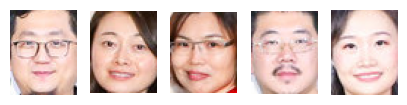

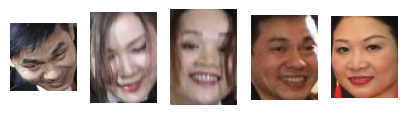

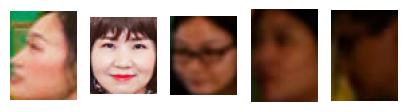

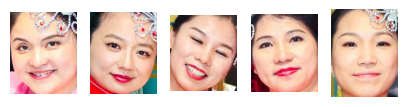

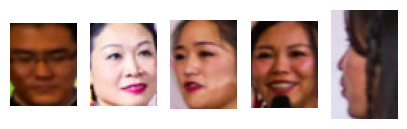

In [ ]:
for x in range(5):
    cluster_0 = df[df['cluster'] == x]
    cluster_0 = cluster_0.reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        image = Image.open(cluster_0['img_path'][i])
        x, y, w, h = cluster_0['bounding_box'][i]
        face = image.crop((x, y, x+w, y+h))
        ax.imshow(face)
        ax.axis("off")

### GhostFacenet

In [18]:
# Extract faces from the dataset

extracted_faces = {
    'img_path': [],
    'bounding_box': [],
    'embedding': []
}

uncessful_images = []

for filename in tqdm(os.listdir(dataset_path)):
    
    if filename.endswith(".jpg"):
        
        img_path = os.path.join(dataset_path, filename)
        faces = extract_faces(img_path, 'GhostFaceNet')
        
        if faces == []:
            uncessful_images.append(filename)
            continue
        
        for face in faces:
            extracted_faces['img_path'].append(img_path)
            extracted_faces['bounding_box'].append(face['bounding_box'])
            extracted_faces['embedding'].append(face['embedding'])

100%|██████████| 672/672 [23:14<00:00,  2.08s/it] 


In [ ]:
print("uncessful_images:", len(uncessful_images))

uncessful_images: 10


In [21]:
df = pd.DataFrame(extracted_faces)
df

,img_path,bounding_box,embedding
0,dataset/63.jpg,"[205, 378, 62, 62]","[-0.050344809889793396, 0.8437319397926331, 0...."
1,dataset/63.jpg,"[1364, 393, 63, 63]","[1.4465656280517578, 2.124927043914795, 0.8046..."
2,dataset/63.jpg,"[1235, 421, 53, 53]","[-0.6851216554641724, 1.3791860342025757, 2.03..."
3,dataset/63.jpg,"[718, 420, 56, 56]","[-1.0279676914215088, 0.16920658946037292, 0.2..."
4,dataset/63.jpg,"[932, 420, 62, 62]","[-1.8936667442321777, -0.525775134563446, -0.3..."
...,...,...,...
3489,dataset/190.jpg,"[612, 405, 71, 71]","[-1.0923508405685425, 0.3647023141384125, -2.0..."
3490,dataset/190.jpg,"[751, 447, 65, 65]","[0.3319155275821686, 0.2396203875541687, 1.956..."
3491,dataset/184.jpg,"[423, 324, 115, 115]","[-0.3670036494731903, 3.236522674560547, -0.14..."
3492,dataset/184.jpg,"[738, 348, 131, 131]","[-0.3694925904273987, 1.238380789756775, 1.131..."


In [22]:
df.to_pickle("result/extract/extracted_faces_ghostfacenet.pkl")

In [10]:
df = pd.read_pickle("result/extract/extracted_faces_ghostfacenet.pkl")

In [11]:
len(df['embedding'].iloc[0])

512

#### Clustering Faces

1. The goal of this section is to cluster the faces based on its embeddings.
2. The result of the clustering will be stored in a seperate folder for each cluster

In [203]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [204]:
embeddings = np.array(df['embedding'].tolist())

In [205]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

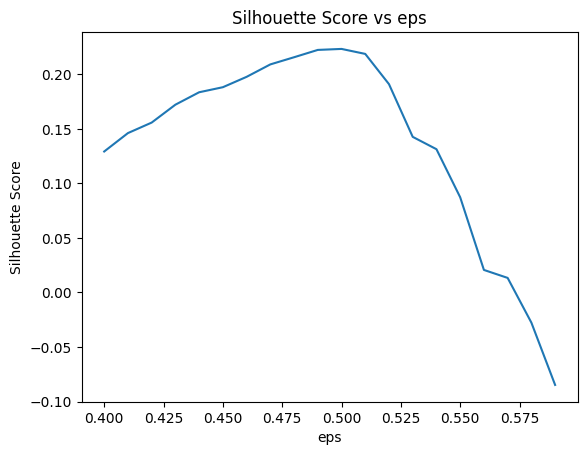

In [206]:
# Get the best eps value

eps_values = np.arange(0.4, 0.6, 0.01)
silhouette_scores = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, metric="cosine")
    clusters = dbscan.fit_predict(embeddings_scaled)
    
    silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
    silhouette_scores.append(silhouette_avg)
    
plt.plot(eps_values, silhouette_scores)
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs eps")
plt.show()

In [207]:
dbscan = DBSCAN(eps=0.5, metric="cosine")
clusters = dbscan.fit_predict(embeddings_scaled)

In [208]:
# Check the number of clusters and noise points
n_clusters_ = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise_ = list(clusters).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 94
Estimated number of noise points: 638


In [209]:
silhouette_avg = silhouette_score(embeddings_scaled, clusters, metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.223


In [210]:
df['cluster'] = clusters

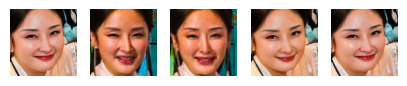

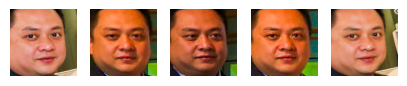

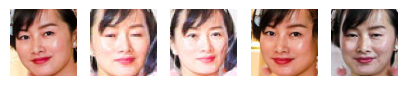

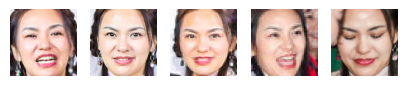

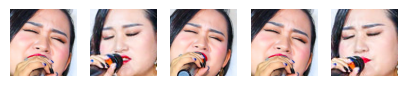

In [182]:
for x in range(20, 25):
    cluster_0 = df[df['cluster'] == x]
    cluster_0 = cluster_0.reset_index(drop=True)

    fig, axes = plt.subplots(1, 5, figsize=(5, 5))

    for i, ax in enumerate(axes.flat):
        image = Image.open(cluster_0['img_path'][i])
        x, y, w, h = cluster_0['bounding_box'][i]
        face = image.crop((x, y, x+w, y+h))
        ax.imshow(face)
        ax.axis("off")

In [13]:
# For each cluster create a folder and save all the images in that cluster

for cluster in set(clusters):
    cluster_path = f"result/cluster/clusters_ghostfacenet/cluster_{cluster}"
    os.makedirs(cluster_path, exist_ok=True)
    
    cluster_df = df[df['cluster'] == cluster]
    
    for i, row in cluster_df.iterrows():
        img_path = row['img_path']
        image = Image.open(img_path)
        x, y, w, h = row['bounding_box']
        face = image.crop((x, y, x+w, y+h))
        
        face.save(f"{cluster_path}/{i}.jpg")

#### Try to improve the clustering by clustering the noise point

In [195]:
# First round of clustering
dbscan_first = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
clusters_first = dbscan_first.fit_predict(embeddings_scaled)

# Identify noise point
noise_indices = np.where(clusters_first == -1)[0]
noise_points = embeddings_scaled[noise_indices]

# Do second round of clustering
dbscan_second = DBSCAN(eps=0.5, min_samples=3, metric='cosine')
clusters_noise = dbscan_second.fit_predict(noise_points)

# The new cluster labels need to be offset to not overlap with original labels
max_label = clusters_first.max()
new_labels = np.where(clusters_noise != -1, clusters_noise + max_label + 1, -1)
clusters_first[noise_indices] = new_labels

# Update the df with the new cluster assignments
df['cluster'] = clusters_first

In [196]:
silhouette_avg = silhouette_score(embeddings_scaled, df['cluster'], metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.001


#### Try to improve the clustering by removing face that appear in same images

In [211]:
#  Faces of the same person cannot be on the same image
# Identify the images that contain faces of the same person (same cluster id)

grouped = df.groupby(['img_path', 'cluster'])

# Finding duplicates
suspect_images = []

for (img_path, cluster_id), group in grouped:
    if cluster_id != -1:
        if len(group) > 1:
            suspect_images.append((img_path, cluster_id, group))

# Output the results
for img_path, cluster_id, images in suspect_images:
    print(f"Image Path: {img_path}, Cluster ID: {cluster_id}")
    print(images[['img_path', 'bounding_box']])
    print()

Image Path: dataset/104.jpg, Cluster ID: 11
             img_path         bounding_box
1451  dataset/104.jpg    [980, 45, 57, 57]
1452  dataset/104.jpg  [1234, 426, 27, 27]

Image Path: dataset/104.jpg, Cluster ID: 12
             img_path        bounding_box
1453  dataset/104.jpg  [322, 430, 38, 38]
1457  dataset/104.jpg  [895, 472, 50, 50]

Image Path: dataset/105.jpg, Cluster ID: 11
             img_path         bounding_box
1575  dataset/105.jpg  [1277, 419, 32, 32]
1580  dataset/105.jpg    [80, 356, 53, 53]

Image Path: dataset/107.jpg, Cluster ID: 11
             img_path        bounding_box
1260  dataset/107.jpg    [747, 4, 61, 61]
1261  dataset/107.jpg  [512, 404, 28, 28]

Image Path: dataset/108.jpg, Cluster ID: 11
             img_path         bounding_box
1599  dataset/108.jpg   [627, 393, 28, 28]
1605  dataset/108.jpg  [1327, 472, 82, 82]

Image Path: dataset/109.jpg, Cluster ID: 11
             img_path         bounding_box
1825  dataset/109.jpg  [1395, 409, 87, 87]
1828  

In [212]:
# Change all this row to cluster -1
for img_path, cluster_id, images in suspect_images:
    for i, row in images.iterrows():
        df.loc[i, 'cluster'] = -1

In [75]:
silhouette_avg = silhouette_score(embeddings_scaled, df['cluster'], metric="cosine")
print('Silhouette Coefficient: %0.3f' % silhouette_avg)

Silhouette Coefficient: 0.338
